In [ ]:
!pip install -q gwpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [ ]:
#@title Loading Model
%%capture
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model = hub.load(SAVED_MODEL_PATH)

In [ ]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [ ]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

# New section

In [ ]:

IMAGE_PATH = "/content/Y9.jpg"

In [ ]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [ ]:
hr_image = preprocess_image(IMAGE_PATH)

In [ ]:
lr_image = downscale_image(tf.squeeze(hr_image))

In [ ]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 6.205040


PSNR Achieved: 33.933334


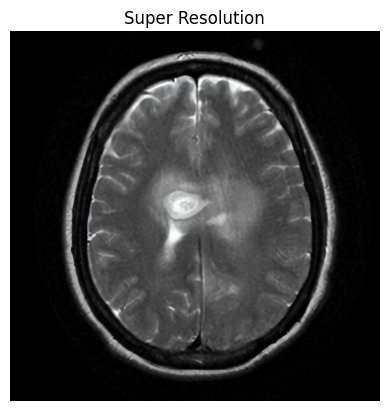

In [ ]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR: 33.933334


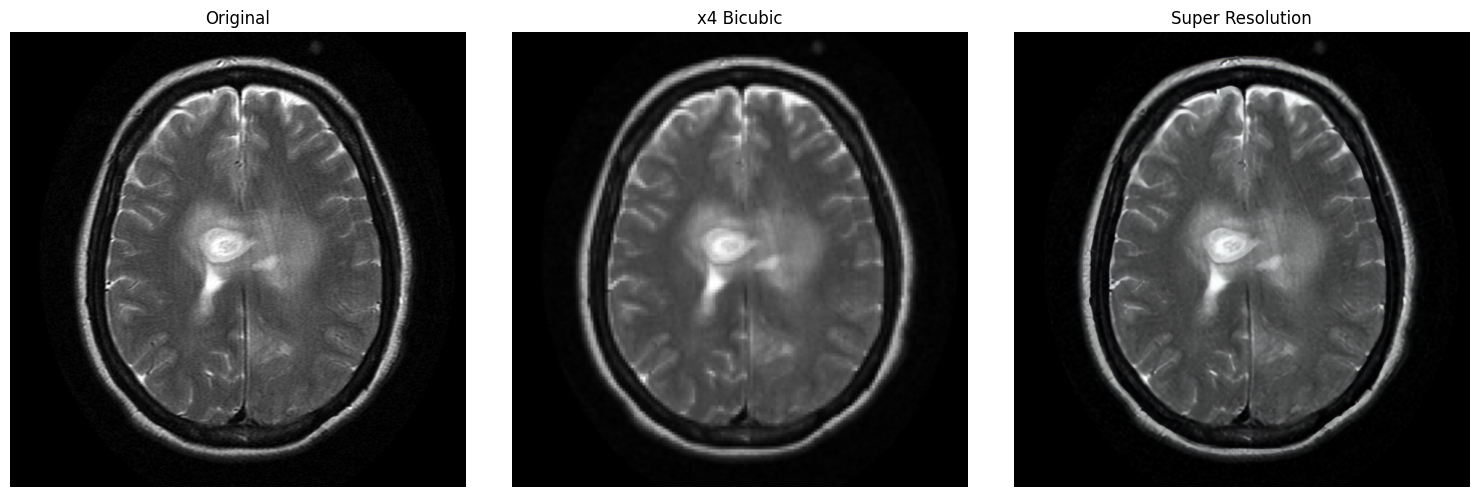

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("comp.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import pathlib
import os
import matplotlib.pyplot as plt

In [ ]:
input_shape = (128, 128, 3)
batch_size = 32
epochs = 120

In [ ]:
!pip install kaggle


In [ ]:
street_dataset = os.path.join("/content/drive/MyDrive/FORcolorize")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
images = list(pathlib.Path(street_dataset).glob("*.jpg"))

In [ ]:
len(images)

154

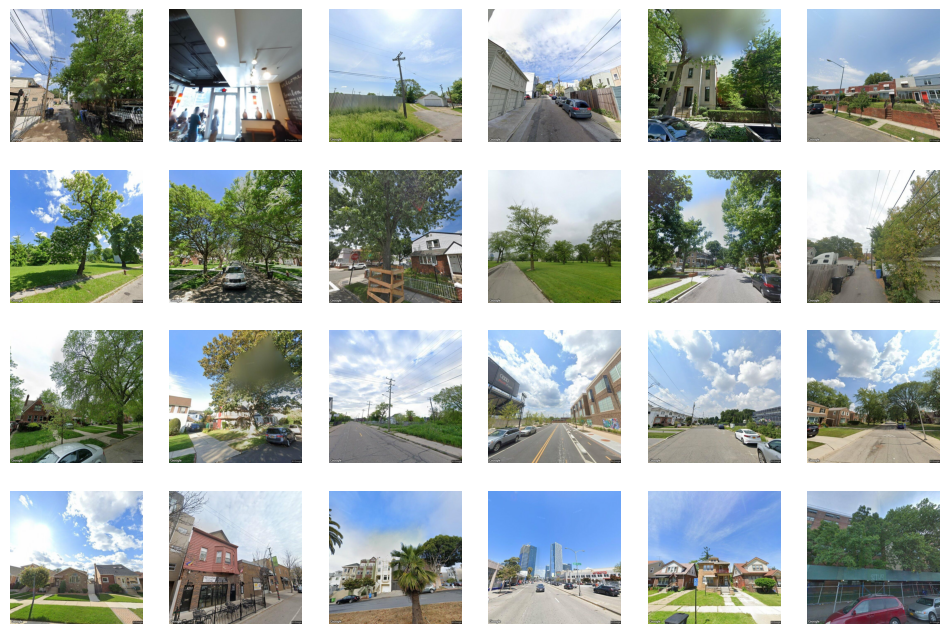

In [ ]:
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Assuming 'images' is a list of file paths
for i in range(min(24, len(images))):
    plt.subplot(4, 6, (i + 1))
    img = cv2.imread(str(images[i]))

    # Check if the image loading is successful
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')

plt.show()


In [ ]:
images = images[:20000]

In [ ]:
len(images)

154

In [ ]:
images_rgb = []
images_greyscale = []
for i in range(len(images)):
  img = cv2.imread(str(images[i]))
  img = img/255
  img = cv2.resize(img, (128, 128))
  img = np.float32(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  images_rgb.append(img)
  images_greyscale.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))

In [ ]:
images_rgb = np.array(images_rgb)
images_greyscale = np.array(images_greyscale)

In [ ]:
images_greyscale.shape

(154, 128, 128)

In [ ]:
images_rgb.shape

(154, 128, 128, 3)

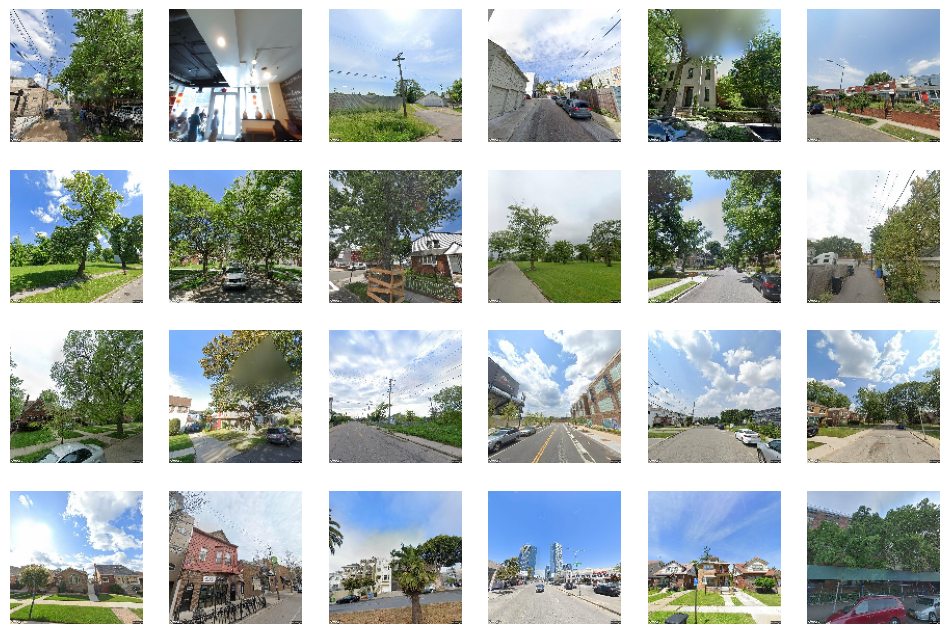

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Assuming 'images_rgb' is a list of RGB images
for i in range(min(24, len(images_rgb))):
    plt.subplot(4, 6, (i + 1))
    plt.imshow(images_rgb[i])
    plt.axis('off')

plt.show()


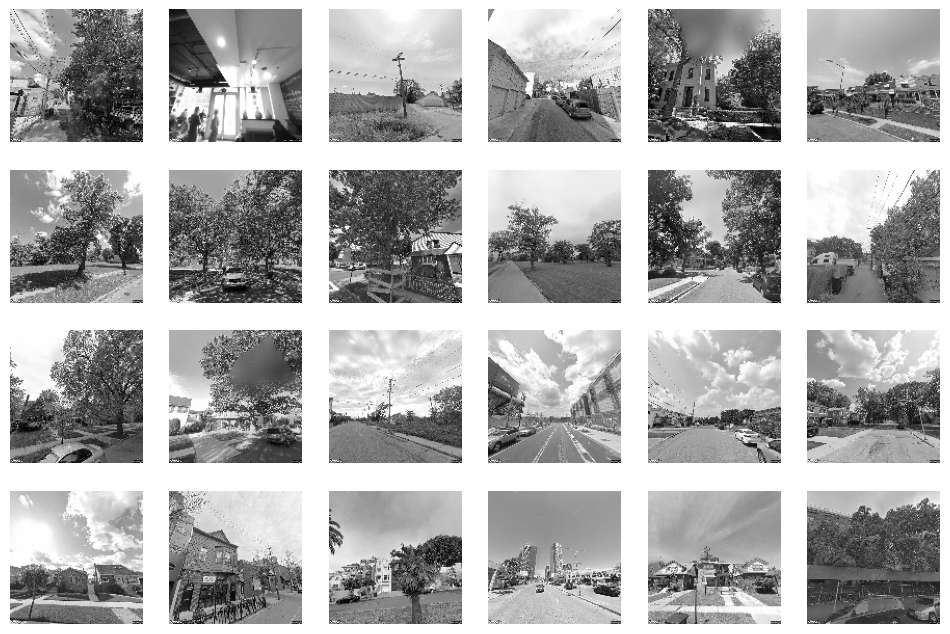

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Assuming 'images_greyscale' is a list of grayscale images
for i in range(min(24, len(images_greyscale))):
    plt.subplot(4, 6, (i + 1))
    plt.imshow(images_greyscale[i], cmap='gray')  # Assuming the images are grayscale
    plt.axis('off')

plt.show()


In [ ]:
from keras import backend as k

In [ ]:
input_encoder = tf.keras.layers.Input(shape = (128, 128, 1))
filters = [32, 64, 128, 256]
x = tf.keras.layers.Conv2D(filters[0], 3, strides = 2, padding = 'same',
                           activation = 'relu')(input_encoder)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)
y = tf.keras.layers.Conv2D(filters[1], 3, strides = 2, padding = "same",
                           activation = "relu")(x)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.concatenate([y,
                             tf.keras.layers.Conv2D(filters[1], 1, strides = 2, padding = "same")(x)])
z = tf.keras.layers.Conv2D(filters[2], 3, strides = 2, padding = "same",
                           activation = "relu")(y)
z = tf.keras.layers.Dropout(0.2)(z)
z = tf.keras.layers.BatchNormalization()(z)
z = tf.keras.layers.concatenate([z,
                             tf.keras.layers.Conv2D(filters[2], 1, strides = 2, padding = "same")(y),
                             tf.keras.layers.Conv2D(filters[2], 1, strides = 4, padding = "same")(x)])
w = tf.keras.layers.Conv2D(filters[3], 3, strides = 2, padding = "same",
                           activation = "relu")(z)
w = tf.keras.layers.Dropout(0.2)(w)
w = tf.keras.layers.BatchNormalization()(w)
w = tf.keras.layers.concatenate([w,
                             tf.keras.layers.Conv2D(filters[3], 1, strides = 2, padding = "same")(z),
                             tf.keras.layers.Conv2D(filters[3], 1, strides = 4, padding = "same")(y),
                             tf.keras.layers.Conv2D(filters[3], 1, strides = 8, padding = "same")(x)])
encoder_shape = k.int_shape(w)
output = tf.keras.layers.BatchNormalization()(w)
output = tf.keras.layers.Activation("elu")(output)
output = tf.keras.layers.Flatten()(output)
output = tf.keras.layers.Dense(512)(output)
encoder_model = tf.keras.models.Model(
    input_encoder, output
)
encoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 64, 64, 32)   320         ['input_4[0][0]']                
                                                                                                  
 dropout_8 (Dropout)            (None, 64, 64, 32)   0           ['conv2d_10[0][0]']              
                                                                                                  
 batch_normalization_10 (BatchN  (None, 64, 64, 32)  128         ['dropout_8[0][0]']        

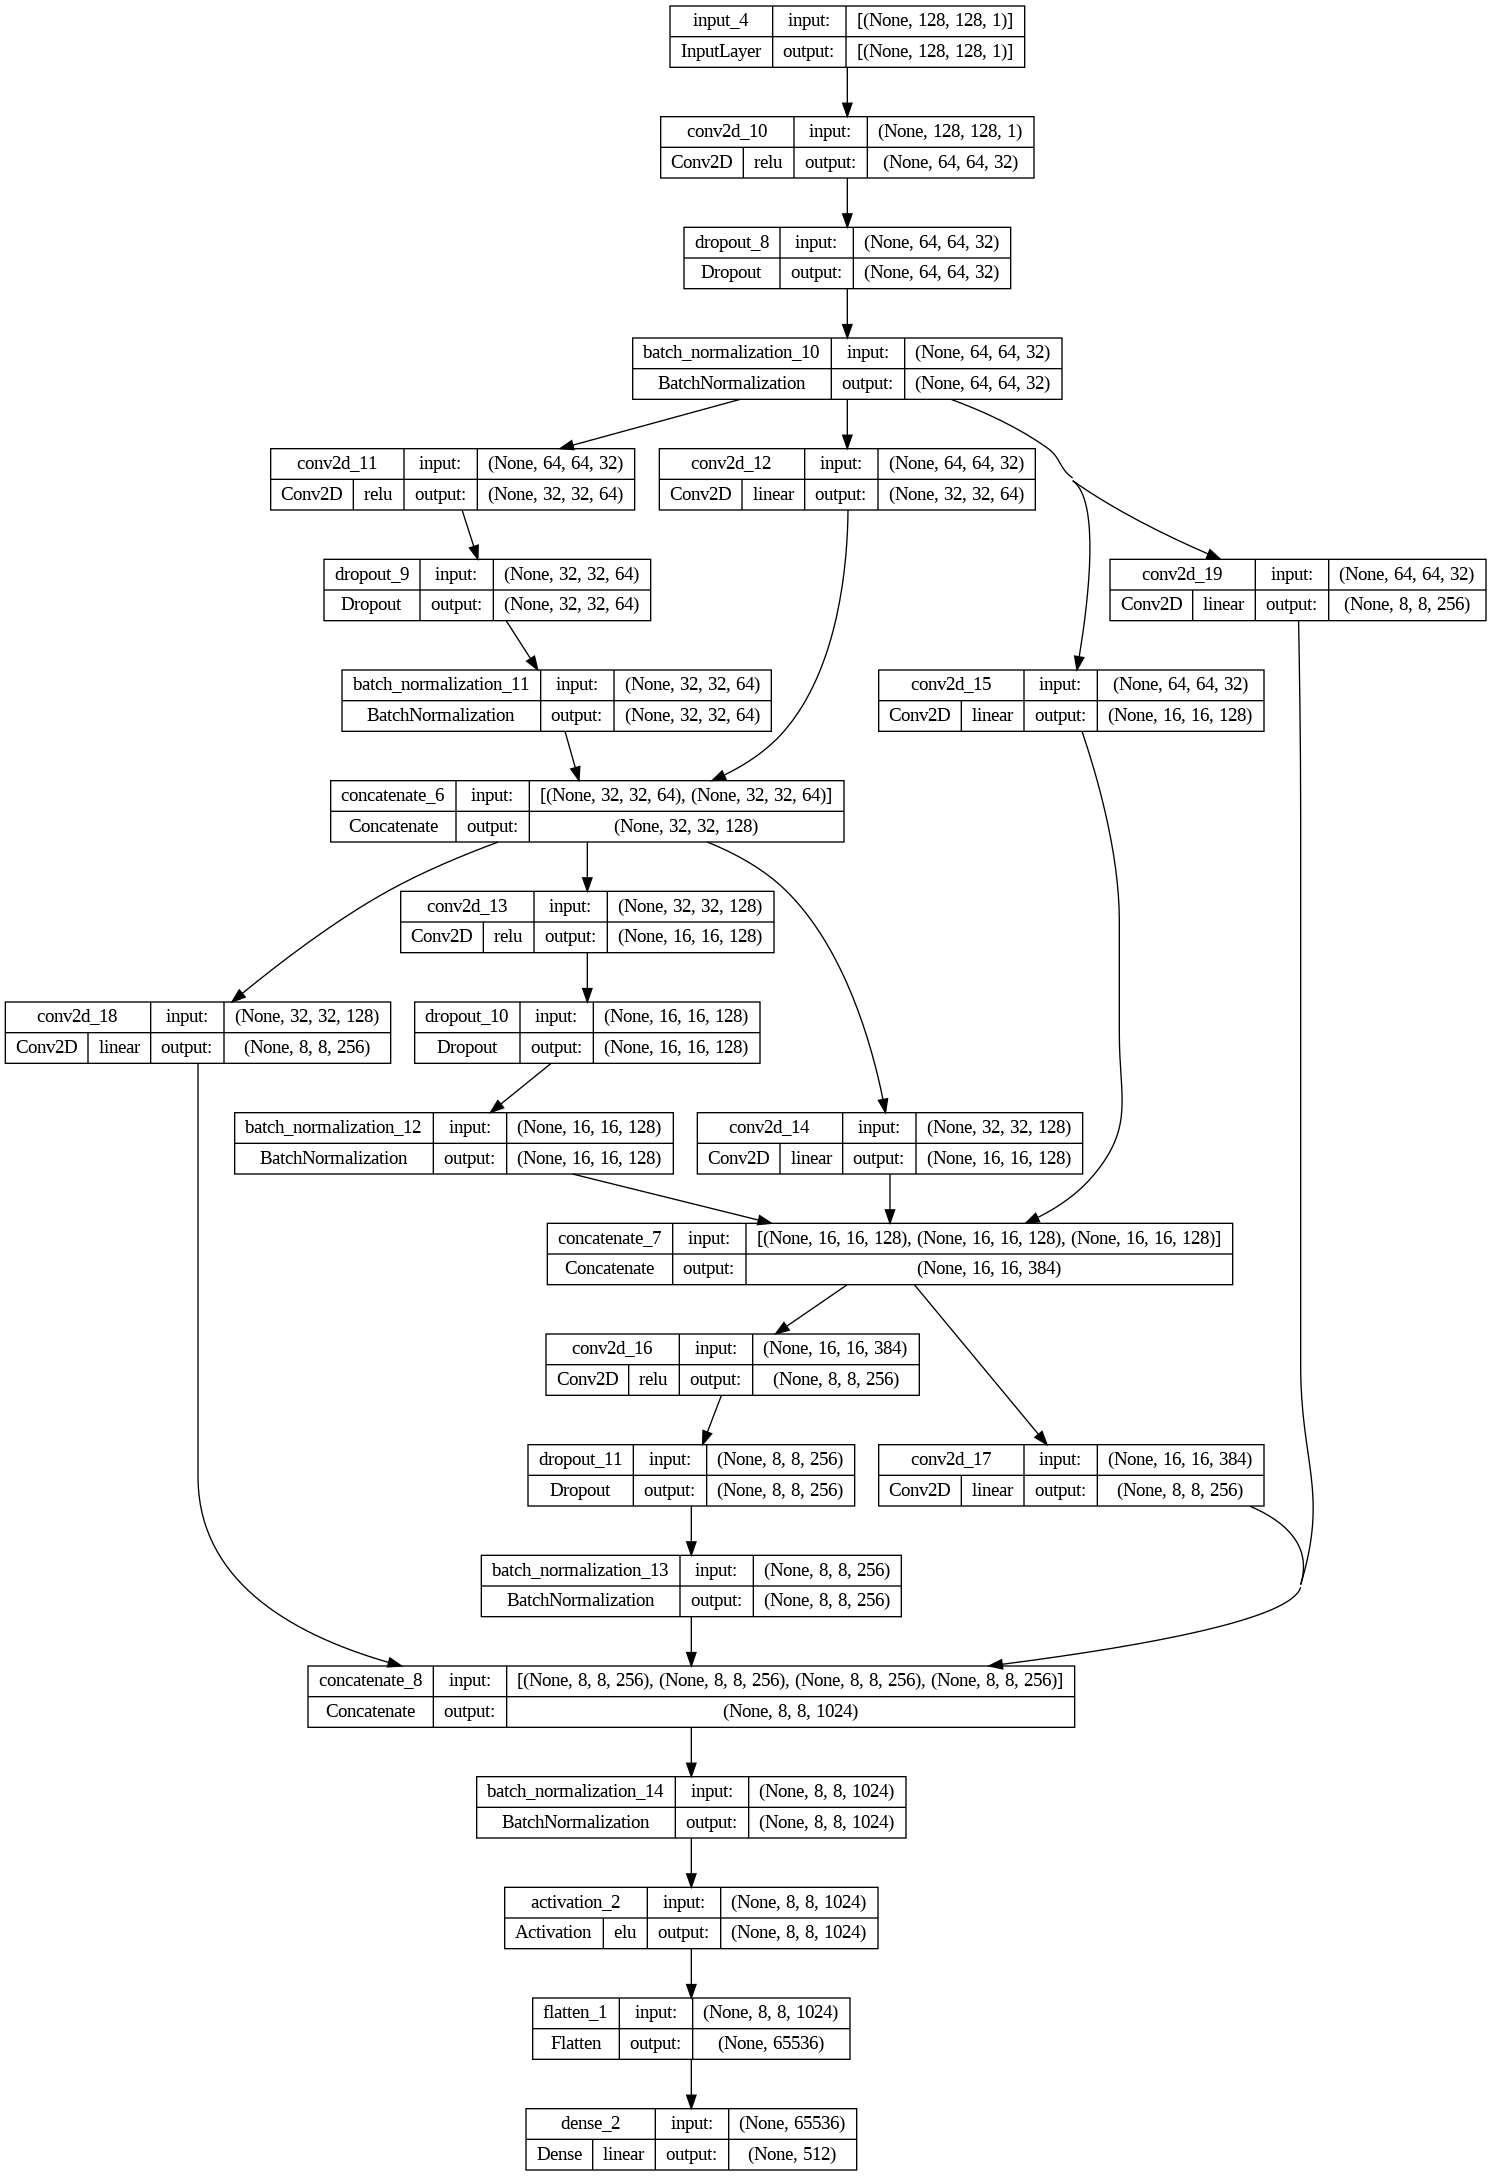

In [ ]:
tf.keras.utils.plot_model(encoder_model, show_shapes = True,
                          show_layer_names = True,
                          show_layer_activations = True)

In [ ]:
input_decoder = tf.keras.layers.Input(shape = (512, ))
r = tf.keras.layers.Dense(encoder_shape[1]*encoder_shape[2]*encoder_shape[3])(input_decoder)
r = tf.keras.layers.Reshape((encoder_shape[1], encoder_shape[2], encoder_shape[3]))(r)
filters = [256, 128, 64, 32]
x = tf.keras.layers.Conv2DTranspose(filters[0], 3, strides = 2, padding = 'same',
                           activation = 'elu')(r)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)
y = tf.keras.layers.Conv2DTranspose(filters[1], 3, strides = 2, padding = "same",
                           activation = "elu")(x)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.concatenate([y,
                             tf.keras.layers.Conv2DTranspose(filters[1], 1, strides = 2, padding = "same")(x)])
z = tf.keras.layers.Conv2DTranspose(filters[2], 3, strides = 2, padding = "same",
                           activation = "elu")(y)
z = tf.keras.layers.Dropout(0.2)(z)
z = tf.keras.layers.BatchNormalization()(z)
z = tf.keras.layers.concatenate([z,
                             tf.keras.layers.Conv2DTranspose(filters[2], 1, strides = 2, padding = "same")(y),
                             tf.keras.layers.Conv2DTranspose(filters[2], 1, strides = 4, padding = "same")(x)])
w = tf.keras.layers.Conv2DTranspose(filters[3], 3, strides = 2, padding = "same",
                           activation = "elu")(z)
w = tf.keras.layers.Dropout(0.2)(w)
w = tf.keras.layers.BatchNormalization()(w)
w = tf.keras.layers.concatenate([w,
                             tf.keras.layers.Conv2DTranspose(filters[3], 1, strides = 2, padding = "same")(z),
                             tf.keras.layers.Conv2DTranspose(filters[3], 1, strides = 4, padding = "same")(y),
                             tf.keras.layers.Conv2DTranspose(filters[3], 1, strides = 8, padding = "same")(x)])
w = tf.keras.layers.BatchNormalization()(w)
w = tf.keras.layers.Conv2DTranspose(3, 3, strides = 1, padding = "same")(w)
output = tf.keras.layers.Activation("sigmoid")(w)
decoder_model = tf.keras.models.Model(
    input_decoder, output
)
decoder_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 65536)        33619968    ['input_5[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 8, 8, 1024)   0           ['dense_3[0][0]']                
                                                                                                  
 conv2d_transpose_11 (Conv2DTra  (None, 16, 16, 256)  2359552    ['reshape_1[0][0]']              
 nspose)                                                                                    

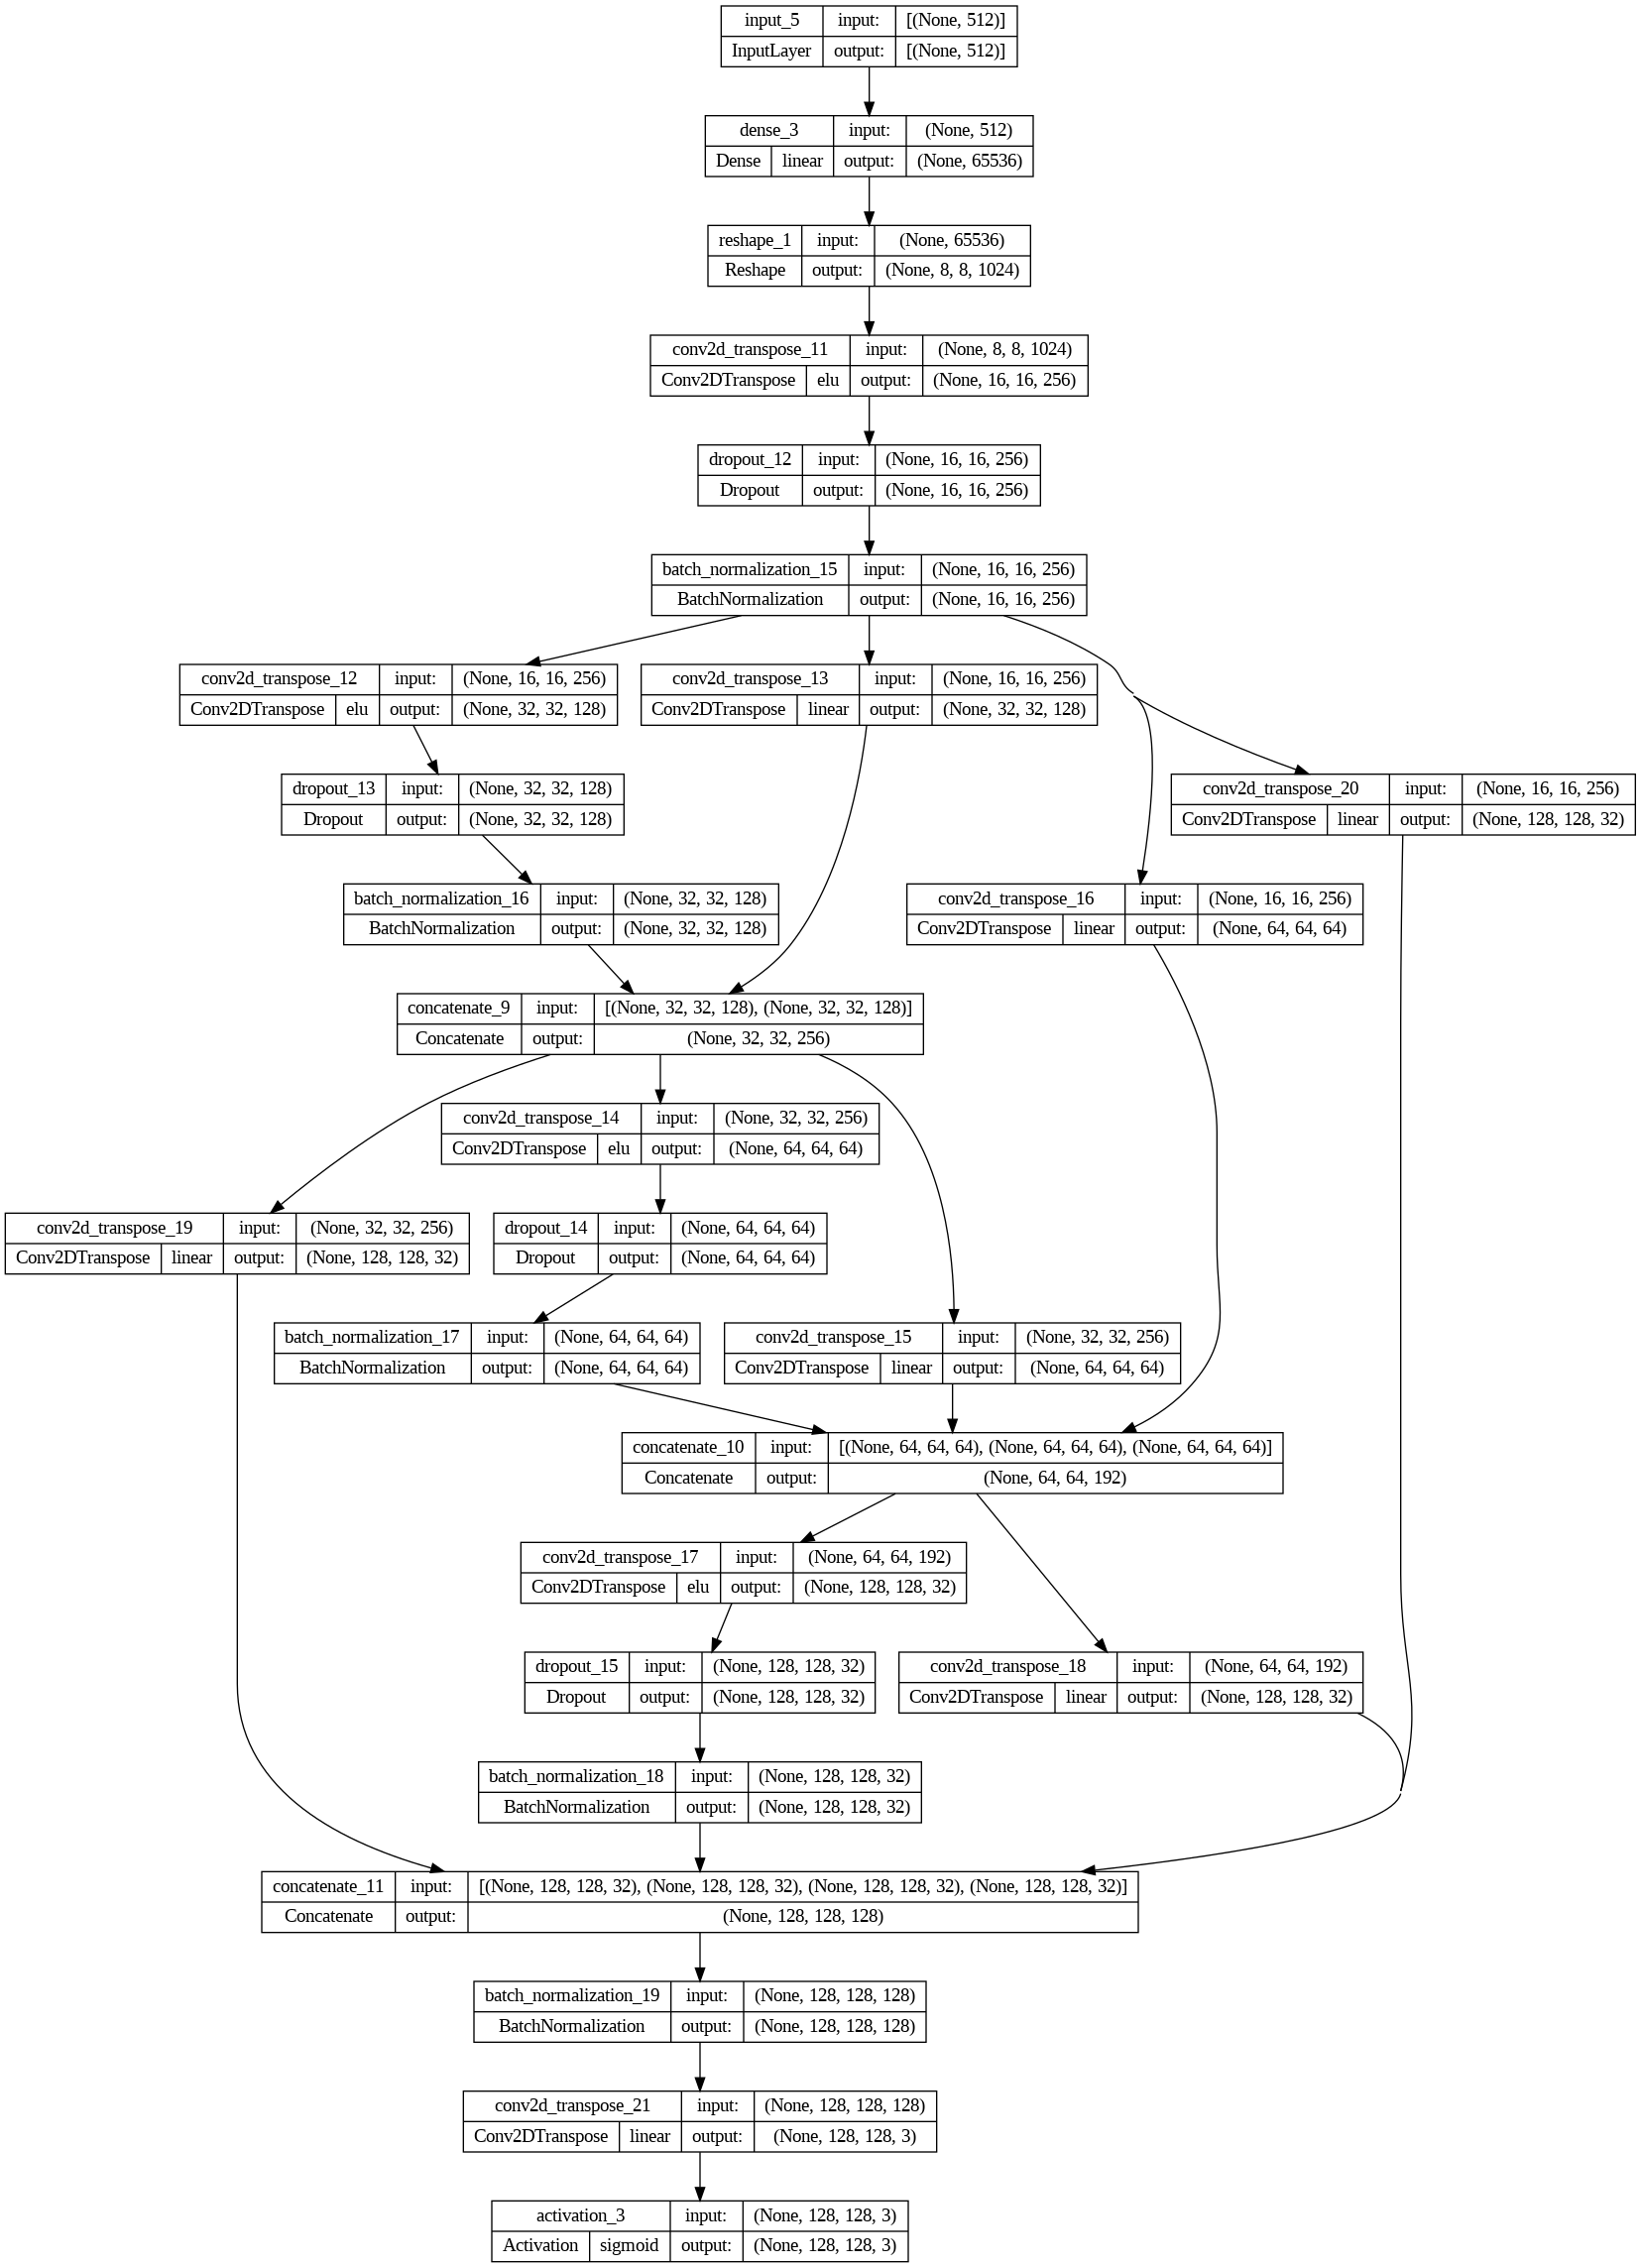

In [ ]:
tf.keras.utils.plot_model(decoder_model, show_shapes = True,
                          show_layer_names = True,
                          show_layer_activations = True)


In [ ]:
input = tf.keras.layers.Input(shape = (128, 128, 1))
autoencoder = tf.keras.models.Model(
    input, decoder_model(encoder_model(input))
)
autoencoder.compile(optimizer = "adam", loss = "mse")
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 model_3 (Functional)        (None, 512)               34775232  
                                                                 
 model_4 (Functional)        (None, 128, 128, 3)       36571715  
                                                                 
Total params: 71,346,947
Trainable params: 71,342,723
Non-trainable params: 4,224
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images_greyscale,
                                                    images_rgb, test_size = 0.2, random_state=True)

In [ ]:
history = autoencoder.fit(x_train, y_train, epochs = epochs, batch_size = 64,
                          validation_data = (x_test, y_test),
                          callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min",
                                                                       patience= 3,
                                                                       restore_best_weights=True),
                                       tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", mode = "min",
                                                                            patience = 2, factor=0.1)])

Epoch 1/120
2/2 [==============================] - 40s 20s/step - loss: 0.0655 - val_loss: 0.0630 - lr: 1.0000e-04
Epoch 2/120
2/2 [==============================] - 36s 19s/step - loss: 0.0640 - val_loss: 0.0638 - lr: 1.0000e-04
Epoch 3/120
2/2 [==============================] - 38s 20s/step - loss: 0.0623 - val_loss: 0.0646 - lr: 1.0000e-04
Epoch 4/120
2/2 [==============================] - 39s 22s/step - loss: 0.0605 - val_loss: 0.0653 - lr: 1.0000e-05


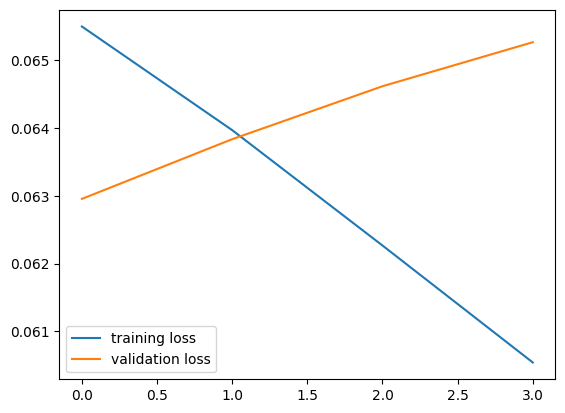

In [ ]:
plt.plot(history.history['loss'], label = "training loss")
plt.plot(history.history['val_loss'], label = "validation loss")
plt.legend()

In [ ]:
autoencoder.evaluate(x_test, y_test)


1/1 [==============================] - 4s 4s/step - loss: 0.0630


0.06295498460531235

In [ ]:
predict_rgb = autoencoder.predict(x_test)

1/1 [==============================] - 2s 2s/step


In [ ]:
predict_rgb.shape

(31, 128, 128, 3)

In [ ]:
import matplotlib.pyplot as plt

def draw_sample_colorize(x_test, y_test, predict_rgb):
    num_samples = min(len(x_test), len(y_test), len(predict_rgb))

    # Ensure that there are enough samples
    if num_samples < 15:
        print("Not enough samples to draw. Exiting.")
        return

    indexs = np.random.choice(range(num_samples), 27)
    all_images = []

    for i in indexs:
        all_images.append(x_test[i])
        all_images.append(y_test[i])
        all_images.append(predict_rgb[i])

    plt.figure(figsize=(7, 12))

    for i in range(27):
        plt.subplot(9, 3, (i + 1))
        plt.imshow(all_images[i])

    plt.show()

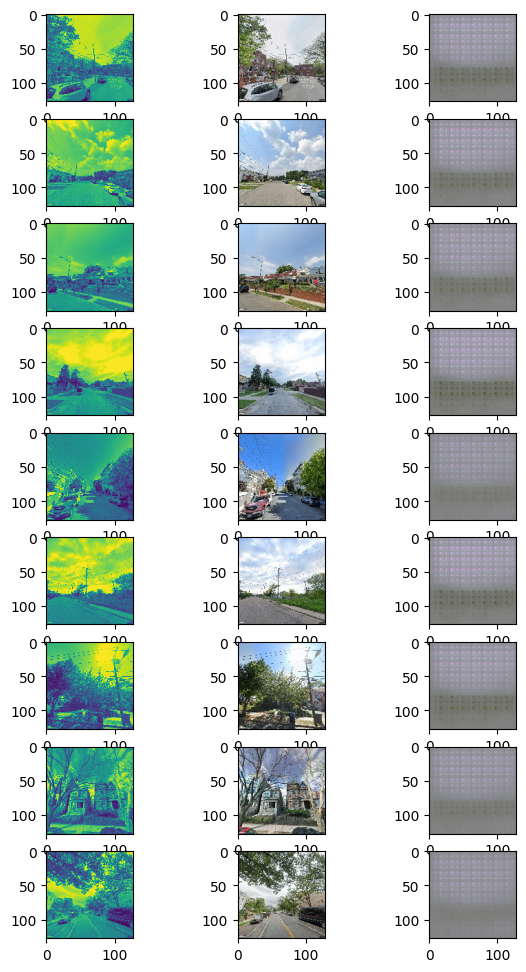

In [ ]:
draw_sample_colorize(x_test, y_test, predict_rgb)

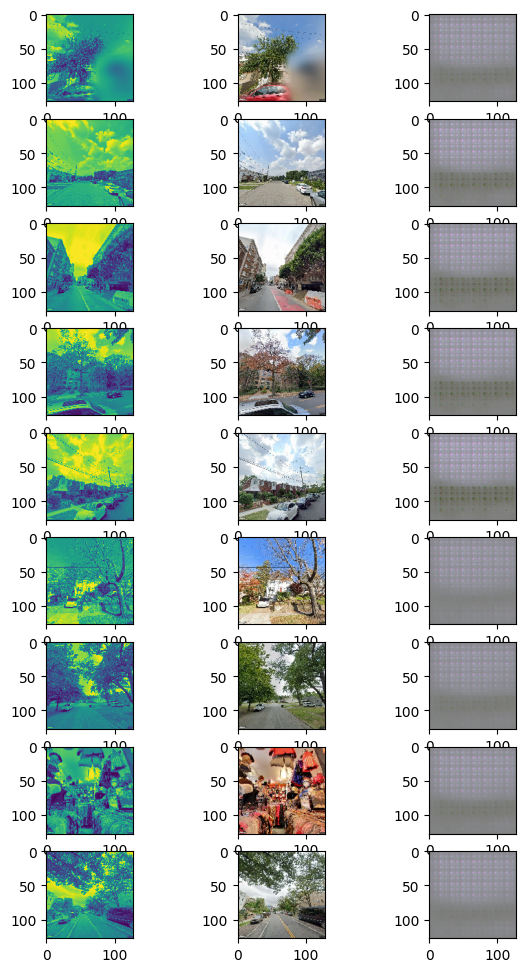

In [ ]:
draw_sample_colorize(x_test, y_test, predict_rgb)

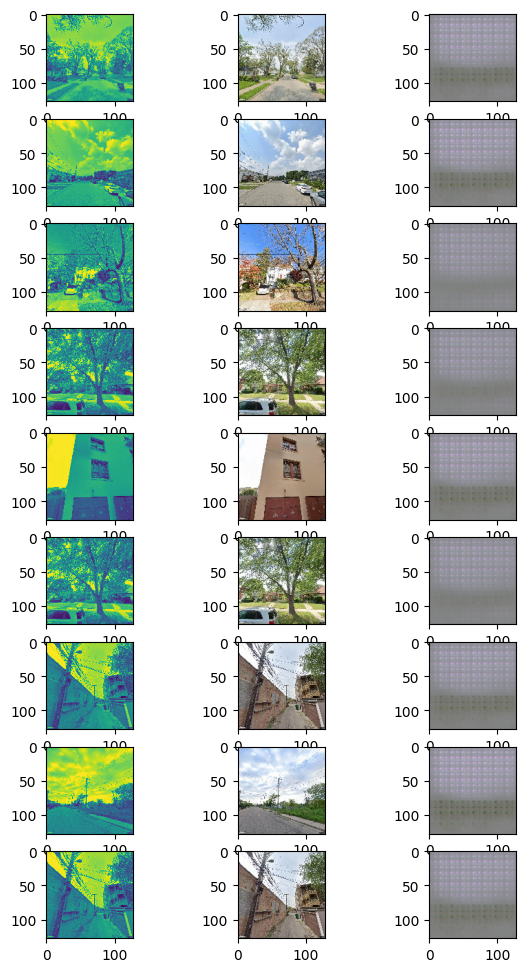

In [ ]:
draw_sample_colorize(x_test, y_test, predict_rgb)

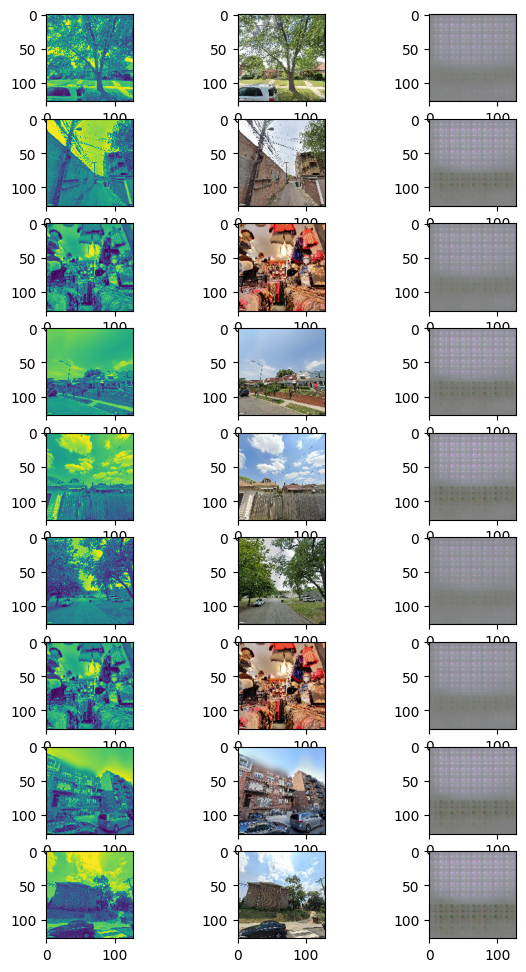

In [ ]:
draw_sample_colorize(x_test, y_test, predict_rgb)

In [ ]:
def enhance_image(image_path, enhancement_model):
    # Load the image
    original_image = plt.imread(image_path)

    # Preprocess the image if needed (resize, normalize, etc.)
    preprocessed_image = preprocess_image(original_image)

    # Use the enhancement model to generate an enhanced version
    enhanced_image = enhancement_model.predict(np.expand_dims(preprocessed_image, axis=0))

    # Postprocess the enhanced image if needed
    postprocessed_image = postprocess_image(enhanced_image)

    # Visualize the original and enhanced images
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image)

    plt.subplot(1, 2, 2)
    plt.title('Enhanced Image')
    plt.imshow(postprocessed_image)

    plt.show()

# Example usage
enhance_image('/content/drive/MyDrive/brainTumor/no/1 no.jpeg', history)


NameError: name 'preprocess_image' is not defined